In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import SVG, display

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, time, glob, shutil
starttime = time.time()
print(os.listdir("../input"))

import warnings
warnings.simplefilter("ignore")

from pathlib import Path
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import glob
from tqdm import tqdm_notebook as tqdm 

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from argparse import Namespace
import numpy as np
import random
import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.utils as vutils

from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint, Timer
from ignite.metrics import RunningAverage

['all-dogs', 'annotation']


In [34]:
args = Namespace(
    seed=123,
    disable_cuda=False,
    device=None,
    debug=False,
    num_workers=2,

    ########## Ignite Stuff ###################
    PRINT_FREQ = 600,
    FAKE_IMG_FNAME = 'fake_sample_epoch_{:04d}.png',
    REAL_IMG_FNAME = 'real_sample_epoch_{:04d}.png',
    LOGS_FNAME = 'logs.tsv',
    PLOT_FNAME = 'plot.svg',
    SAMPLES_FNAME = 'samples.svg',
    CKPT_PREFIX = 'networks',
    output_dir = '../output_dir/',
    alpha = 0.98, #smoothign constant for exponential moving average
    
    ######### Dataset Related #################
    shuffle=True,
    datapath=Path('../input/all-dogs/'),
    root_images=Path("../input/all-dogs/all-dogs/"),
    root_annots=Path("../input/annotation/Annotation/"),
    
    ######### Training Params ######################
    num_epochs=50,
    lr=1e-3,
    beta1 = 0.5, # for adam
    batch_size=32,
    weight_decay=0.001,
    log_interval=100,
    num_disc_update=3,

    ######### Model Params #########################
    image_size=64,
    in_channels=3,
    num_feature_maps_gen=64,
    num_feature_maps_disc=64,
    latent_dim=128,
    input_dim=64*64,
    hidden_size=400,    
    dropout_p=0.2,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Random Seed: ", args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed);

Random Seed:  123


In [26]:
### All utility functions
def get_bbox(img_path):
    "image path as input and return list of bounding boxes around dogs (could be more than one per image)"
    annotation_basename = os.path.splitext(os.path.basename(img_path))[0]
    annotation_dirname = next(dirname for dirname in os.listdir('../input/annotation/Annotation/') if dirname.startswith(annotation_basename.split('_')[0]))
    annotation_filename = os.path.join('../input/annotation/Annotation', annotation_dirname, annotation_basename)
    tree = ET.parse(annotation_filename)
    root = tree.getroot()
    objects = root.findall('object')
    bboxes = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bboxes.append((xmin, ymin, xmax, ymax))
    return bboxes

def doggo_loader(img_path):
    img = torchvision.datasets.folder.default_loader(img_path) # default loader
    bbox = get_bbox(img_path)[-1]
    return img.crop(bbox)

def clear_output_dir():
    try:
        shutil.rmtree(args.output_dir)
    except FileNotFoundError:
        pass

def check_gen_samples(dataloader, img_list):
    "Plot tile of real and generated images"
    
    real_batch = next(iter(dataloader))
    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [37]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1, transform2=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in tqdm(self.img_names):
            img_path = os.path.join(img_dir, img_name)
            img = Image.open(img_path)
            bboxes = get_bbox(img_path)
            
            for bbox in bboxes:
                img_crop = img.crop(bbox)
                self.imgs.append(self.transform1(img_crop))

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

def get_transforms():
    
    # this normalizes pixel values between [-1,1]
    # https://www.kaggle.com/jesucristo/gan-introduction565419
    # GANHACK #1
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    random_transforms = [transforms.ColorJitter(), 
                         transforms.RandomRotation(degrees=3)]
    random_cropper = [torchvision.transforms.CenterCrop(args.image_size), torchvision.transforms.RandomCrop(args.image_size)]


    # First preprocessing of data
    transform1 = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
    ])

    transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(random_transforms, p=0.4),
        transforms.ToTensor(),
        normalize]) 
    
    return transform1, transform2

transform1, transform2 = get_transforms()
train_data = DogDataset(img_dir='../input/all-dogs/all-dogs/',
                           transform1=transform1,
                           transform2=transform2)

dataloader = torch.utils.data.DataLoader(train_data, 
                                         shuffle=True,
                                         batch_size=args.batch_size, 
                                         num_workers=args.num_workers)

In [28]:
## All Model Related

class Net(nn.Module):
    """ 
    A base class for both generator and the discriminator.
    Provides a common weight initialization scheme.
    """
    def weights_init(self):
        for m in self.modules():
            classname = m.__class__.__name__

            if 'Conv' in classname:
                m.weight.data.normal_(0.0, 0.02)

            elif 'BatchNorm' in classname:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

    def forward(self, x):
        return x

class Generator(Net):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        def conv_block(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, k_size, stride, padding, bias=False),
                nn.BatchNorm2d(n_output),
#                 nn.LeakyReLU(0.2, inplace=True),
                nn.ReLU(inplace=True),                
            ]
            return block
        
        self.project = nn.Sequential(
            nn.Linear(args.latent_dim, 256 * 4 * 4),
            nn.BatchNorm1d(256 * 4 * 4),
            nn.ReLU(inplace=True),
        )
        self.main = nn.Sequential(
            *conv_block(args.latent_dim, args.num_feature_maps_gen * 8, 4, 1, 0),
            # state size. (args.num_feature_maps_gen * 8) x 4 x 4
            *conv_block(args.num_feature_maps_gen * 8, args.num_feature_maps_gen * 4, 4, 2, 1),
            # state size. (args.num_feature_maps_gen*4) x 8 x 8
            *conv_block(args.num_feature_maps_gen * 4, args.num_feature_maps_gen * 2, 4, 2, 1),
            # state size. (args.num_feature_maps_gen*2) x 16 x 16
            *conv_block(args.num_feature_maps_gen * 2, args.num_feature_maps_gen * 1, 4, 2, 1),
            # state size. (args.num_feature_maps_gen) x 32 x 32
            nn.ConvTranspose2d( args.num_feature_maps_gen, args.in_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (args.in_channels) x 64 x 64
        )
        self.weights_init()

    def forward(self, input):
        return self.main(input)
    
class Discriminator(Net):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (in_channels) x 64 x 64
            nn.Conv2d(in_channels=args.in_channels, out_channels=args.num_feature_maps_disc, 
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.PReLU(),
            # state size. (args.num_feature_maps_disc) x 32 x 32
            nn.Conv2d(args.num_feature_maps_disc, args.num_feature_maps_disc * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.num_feature_maps_disc * 2),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.PReLU(),
            # state size. (args.num_feature_maps_disc * 2) x 16 x 16
            nn.Conv2d(args.num_feature_maps_disc * 2, args.num_feature_maps_disc * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.num_feature_maps_disc * 4),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.PReLU(),
            # state size. (args.num_feature_maps_disc * 4) x 8 x 8
            nn.Conv2d(args.num_feature_maps_disc * 4, args.num_feature_maps_disc * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(args.num_feature_maps_disc * 8),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.PReLU(),
            # state size. (args.num_feature_maps_disc * 8) x 4 x 4
            nn.Conv2d(args.num_feature_maps_disc * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )
        self.weights_init()

    def forward(self, input):
        return self.main(input)

In [29]:
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, args.latent_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=args.lr/2.0, betas=(args.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=args.lr, betas=(args.beta1, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizerD, factor=0.5, patience=2, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizerD, gamma=0.5, step_size=8)

def step(engine, batch):
    real_cpu_batch = batch.to(device)
    args.batch_size = real_cpu_batch.size(0)
    label = torch.full((args.batch_size,), real_label, device=device)
    
    for _ in range(args.num_disc_update):
        netD.zero_grad()

        # train separately with all trues and all fake images
        # GANHACK #4 
        ## Train with all-real batch
        # Forward pass real batch through D

        outputR = netD(real_cpu_batch).view(-1)
        D_x = outputR.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # Sampling from Gaussian Space is GANHACKS #3
        noise = torch.randn(args.batch_size, args.latent_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)

        # Classify all fake batch with D
        outputF = netD(fake.detach()).view(-1)
        D_G_z1 = outputF.mean().item()

        # RalsGAN loss function
        ### Relativistic average LSGAN
        # https://github.com/AlexiaJM/RelativisticGAN
        errD = (torch.mean((outputR - torch.mean(outputF) - label) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + label) ** 2))/2
        errD.backward(retain_graph=True)

        # Update D
        optimizerD.step()
        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    # Since we just updated D, perform another forward pass of all-fake batch through D
    outputF = netD(fake).view(-1)
    # Calculate G's loss based on this output (RalSGAN)
    ### Relativistic average LSGAN
    # https://github.com/AlexiaJM/RelativisticGAN
    errG = (torch.mean((outputR - torch.mean(outputF) + label) ** 2) +
            torch.mean((outputF - torch.mean(outputR) - label) ** 2))/2
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = outputF.mean().item()
    # Update G
    optimizerG.step()
    
    return {
            'errD': errD.item(),
            'errG': errG.item(),
            'D_x': D_x,
            'D_G_z1': D_G_z1,
            'D_G_z2': D_G_z2
    }

In [36]:
clear_output_dir()

# ignite objects
trainer = Engine(step)
checkpoint_handler = ModelCheckpoint(args.output_dir, args.CKPT_PREFIX, save_interval=1, n_saved=10, require_empty=False)
timer = Timer(average=True)

# attach running average metrics
monitoring_metrics = ['errD', 'errG', 'D_x', 'D_G_z1', 'D_G_z2']
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['errD']).attach(trainer, 'errD')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['errG']).attach(trainer, 'errG')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['D_x']).attach(trainer, 'D_x')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['D_G_z1']).attach(trainer, 'D_G_z1')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['D_G_z2']).attach(trainer, 'D_G_z2')

# attach progress bar
pbar = ProgressBar()
pbar.attach(trainer, metric_names=monitoring_metrics)

# adding handlers using `trainer.on` decorator API
@trainer.on(Events.ITERATION_COMPLETED)
def print_logs(engine):
    if (engine.state.iteration - 1) % args.PRINT_FREQ == 0:
        fname = os.path.join(args.output_dir, args.LOGS_FNAME)
        columns = ["iteration", ] + list(engine.state.metrics.keys())
        values = [str(engine.state.iteration), ] + \
                 [str(round(value, 5)) for value in engine.state.metrics.values()]
        with open(fname, 'a') as f:
            if f.tell() == 0:
                print('\t'.join(columns), file=f)
            print('\t'.join(values), file=f)

        message = '[{epoch}/{max_epoch}][{i}/{max_i}]'.format(epoch=engine.state.epoch,
                                                              max_epoch=args.num_epochs,
                                                              i=(engine.state.iteration % len(dataloader)),
                                                              max_i=len(dataloader))
        for name, value in zip(columns, values):
            message += ' | {name}: {value}'.format(name=name, value=value)
        pbar.log_message(message)

@trainer.on(Events.EPOCH_COMPLETED)
def save_fake_example(engine):
    fake = netG(fixed_noise).detach().cpu()
    path = os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image((fake+1.)/2., path, normalize=True)
    
@trainer.on(Events.EPOCH_COMPLETED)
def save_real_example(engine):
    img = engine.state.batch
    path = os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image(img, path, normalize=True)
    
# adding handlers using `trainer.add_event_handler` method API
trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED, 
                          handler=checkpoint_handler,
                          to_save={
                              'netG': netG,
                              'netD': netD
                          })

# automatically adding handlers via a special `attach` method of `Timer` handler
timer.attach(trainer, 
             start=Events.EPOCH_STARTED, 
             resume=Events.EPOCH_STARTED,
             pause=Events.EPOCH_COMPLETED, 
             step=Events.EPOCH_COMPLETED)

@trainer.on(Events.EPOCH_COMPLETED)
def print_times(engine):
    pbar.log_message(f'Epoch {engine.state.epoch} done. Time per epoch: {timer.value()/60:.3f}[min]')
    timer.reset()
    
@trainer.on(Events.EPOCH_COMPLETED)
def create_plots(engine):
    try:
        import matplotlib as mpl
        mpl.use('agg')

        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt

    except ImportError:
        warnings.warn('Loss plots will not be generated -- pandas or matplotlib not found')

    else:
        df = pd.read_csv(os.path.join(args.output_dir, args.LOGS_FNAME), delimiter='\t', index_col='iteration')
        _ = df.loc[:, list(engine.state.metrics.keys())].plot(subplots=True, figsize=(10, 10))
        _ = plt.xlabel('Iteration number')
        fig = plt.gcf()
        path = os.path.join(args.output_dir, args.PLOT_FNAME)
        fig.savefig(path)
        
@trainer.on(Events.EXCEPTION_RAISED)
def handle_exception(engine, e):
    if isinstance(e, KeyboardInterrupt) and (engine.state.iteration > 1):
        engine.terminate()
        warnings.warn('KeyboardInterrupt caught. Exiting gracefully.')

        create_plots(engine)
        checkpoint_handler(engine, {
            'netG_exception': netG,
            'netD_exception': netD
        })

    else:
        raise e
        
trainer.run(dataloader, args.num_epochs)

[1/50][1/346] | iteration: 1 | errD: 0.01632 | errG: 4.03112 | D_x: -0.49674 | D_G_z1: -1.56075 | D_G_z2: -1.50216


In [31]:
df = pd.read_csv(os.path.join(args.output_dir, args.LOGS_FNAME), delimiter='\t', index_col='iteration')
# df

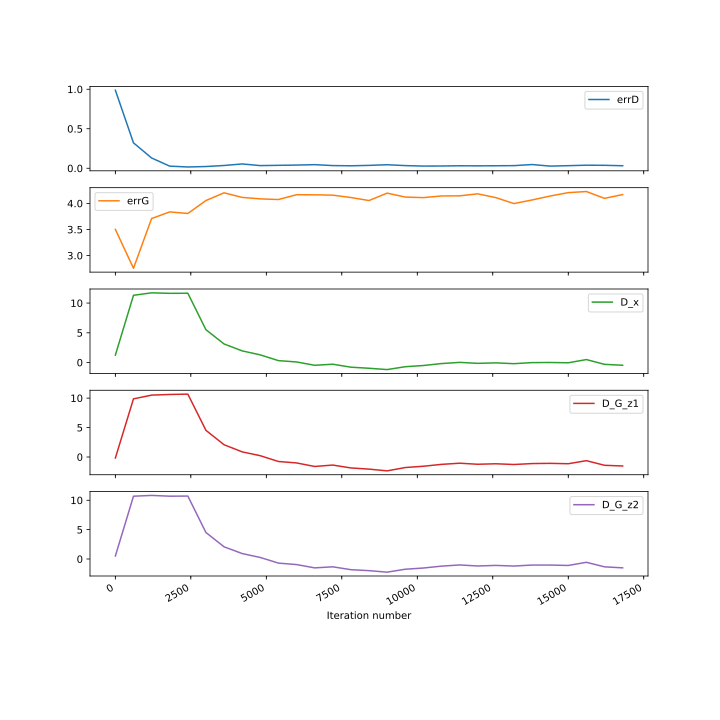

In [32]:
# analysize logs
display(SVG("../output_dir/plot.svg"))

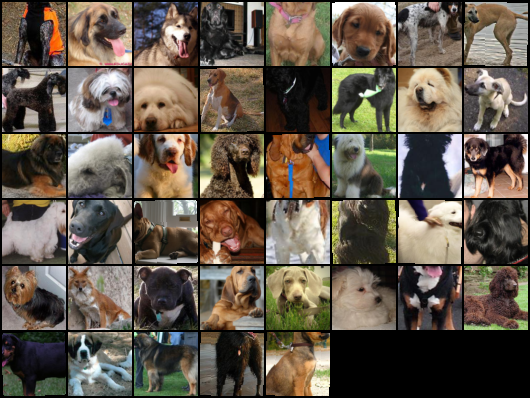

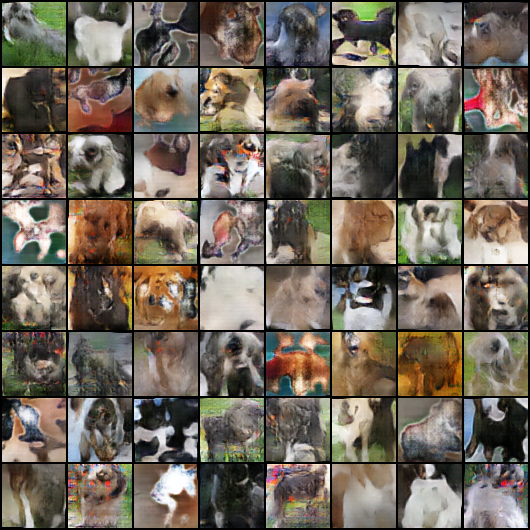

In [33]:
display(Image.open(os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(args.num_epochs-1))))
display(Image.open(os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(args.num_epochs-1))))

In [21]:
%%time
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, args.latent_dim, 1, 1, device=device)
    gen_images = (netG(gen_z)+1.)/2. # denormalize
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')
print(f"Done in {(time.time() - starttime)/60:.4f} minutes.")

Done in 15.6669 minutes.
CPU times: user 15.4 s, sys: 2.39 s, total: 17.8 s
Wall time: 18.2 s
